### Preliminaries


Additional Indicators

In [119]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
random_state = 0
import seaborn as sns
sys.path.append(os.path.dirname(os.getcwd()))
from data_prep import fetch_data, time_series_features, add_lag_features, simple_moving_average
# from mean_reversion import mean_reversion_strategy
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import pandas_ta as ta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K

### Fetch Data

In [230]:
df = fetch_data('XOM', '1990-01-01', '2023-12-31')
# df['SMA_10'] = simple_moving_average(df, 10)
df = df.reset_index()
df['Date'] = df['Date'].dt.date
df.drop(columns=['Open', 'Volume', 'High','Low', 'Dividends', 'Stock Splits'], inplace=True)
# df['Close_diff'] = df['Close'].diff(1)
df


,Date,Close
0,1990-01-02,3.898286
1,1990-01-03,3.859300
2,1990-01-04,3.820321
3,1990-01-05,3.800829
4,1990-01-08,3.859300
...,...,...
8560,2023-12-22,99.358170
8561,2023-12-26,99.582397
8562,2023-12-27,99.114418
8563,2023-12-28,97.681229


### Data Preparation

In [231]:
df = add_lag_features(df)
df['RSI_15'] = (ta.rsi(df['Close'], length=15)).shift(1)

# df = time_series_features(df)
cols = list(df.columns)
cols.remove('Close')
cols.append('Close')
df = df[cols]
df = df.dropna()

In [232]:
df

,Date,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_5,Close_lag_10,RSI_15,Close
16,1990-01-24,3.674133,3.664387,3.791081,3.693625,3.800829,35.469892,3.664387
17,1990-01-25,3.664387,3.674133,3.664387,3.742356,3.820321,34.726826,3.586423
18,1990-01-26,3.586423,3.664387,3.674133,3.791081,3.722862,29.440649,3.644897
19,1990-01-29,3.644897,3.586423,3.664387,3.664387,3.771590,37.131061,3.664387
20,1990-01-30,3.664387,3.644897,3.586423,3.674133,3.752097,39.486332,3.664387
...,...,...,...,...,...,...,...,...
8560,2023-12-22,99.182671,98.734177,100.411118,98.373451,97.057251,48.061437,99.358170
8561,2023-12-26,99.358170,99.182671,98.734177,99.104668,97.125504,48.692527,99.582397
8562,2023-12-27,99.582397,99.358170,99.182671,100.411118,95.594810,49.531981,99.114418
8563,2023-12-28,99.114418,99.582397,99.358170,98.734177,96.443024,47.783759,97.681229


In [233]:
def windowed_df_to_date(df):
    dates = df['Date'].values
    features = df.drop(['Date', 'Close'], axis=1).values
    X = features.reshape((len(dates), features.shape[1], 1))
    y = df['Close'].values
    return X.astype(np.float32), y.astype(np.float32), dates

X, y, dates = windowed_df_to_date(df)


In [234]:
X = deepcopy(np.flip(X, axis = 1))

### Train/Val/Test Split


In [235]:
q_80 = int(len(df) * 0.8)
q_90 = int(len(df) * 0.9)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

dates_train = dates[:q_80]
dates_val = dates[q_80:q_90]
dates_test = dates[q_90:]

X_train = X_scaled[:q_80]
X_val = X_scaled[q_80:q_90]
X_test = X_scaled[q_90:]

y_train = y_scaled[:q_80]
y_val = y_scaled[q_80:q_90]
y_test = y_scaled[q_90:]

# df.loc[df.index < '2023-06-30']

In [236]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train sample:", X_train[0])
print("y_train sample:", y_train[0])

X_train shape: (6839, 6, 1)
y_train shape: (6839,)
X_train sample: [[-0.116692 ]
 [-1.451659 ]
 [-1.4561781]
 [-1.45207  ]
 [-1.4574106]
 [-1.4569997]]
y_train sample: -1.2894512


## Model

In [237]:
start_lr = 1e-8
end_lr = 1
# def lr_schedule(epoch, lr):
#     return lr * (end_lr/start_lr) ** (1/100)

# losses = []
# lrs = []
# lr_callback = LambdaCallback(on_batch_end=lambda batch, logs: lrs.append(K.get_value(model.optimizer.learning_rate)))
# loss_callback = LambdaCallback(on_batch_end=lambda batch, logs: losses.append(logs['loss']))


In [238]:
# learning_rates = [0.01, 0.03, 0.05, 0.08, 0.1, 0.001]
# histories = []
# models = []

# for lr in learning_rates:
#     model = Sequential([
#         layers.Input((X_train.shape[1], 1)),
#         layers.LSTM(64, return_sequences=True),
#         layers.LSTM(32),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(1)
#     ])

#     model.compile(loss='mse', 
#                   optimizer=Adam(learning_rate=lr), 
#                   metrics=['mean_absolute_error'])

#     history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), verbose=1)
    
#     histories.append(history)
#     models.append(model)

# Find the best model based on validation loss


### 

### Visualization

#### Loss Visualization

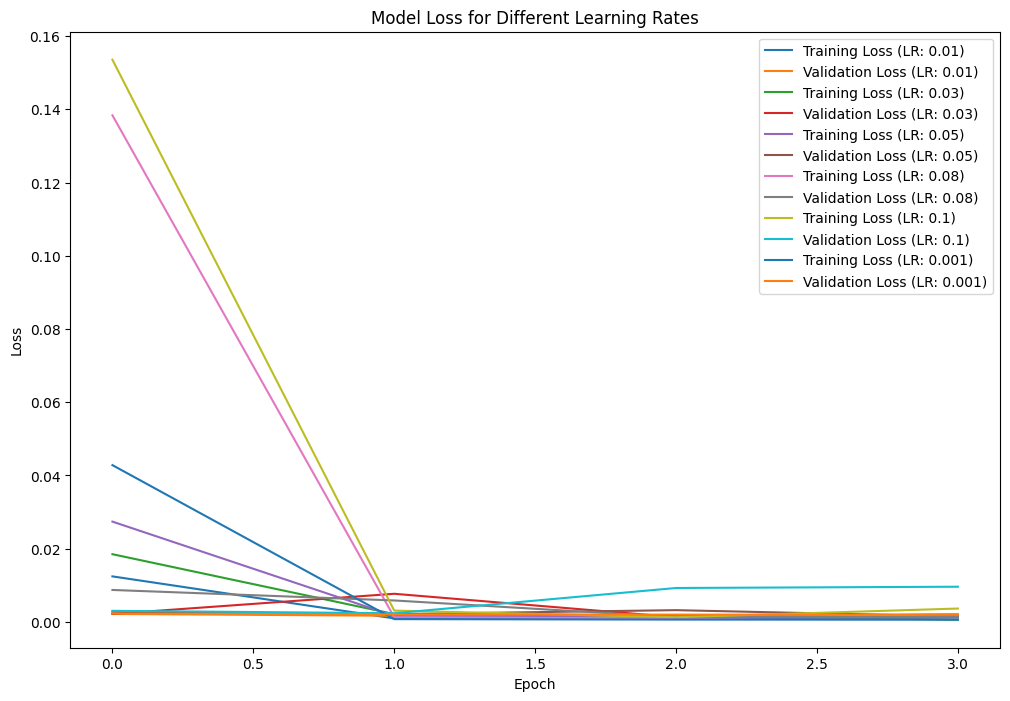

In [239]:
plt.figure(figsize=(12, 8))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (LR: {learning_rates[i]})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR: {learning_rates[i]})')

plt.title('Model Loss for Different Learning Rates')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### MAE Visualization

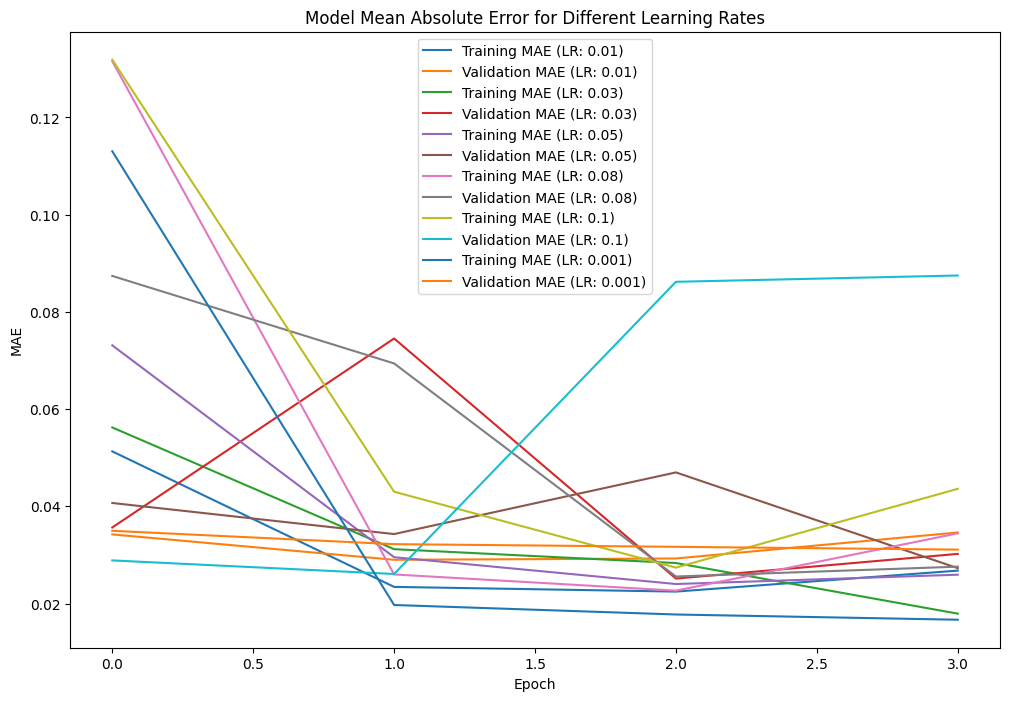

In [240]:
plt.figure(figsize=(12, 8))
for i, history in enumerate(histories):
    plt.plot(history.history['mean_absolute_error'], label=f'Training MAE (LR: {learning_rates[i]})')
    plt.plot(history.history['val_mean_absolute_error'], label=f'Validation MAE (LR: {learning_rates[i]})')
plt.title('Model Mean Absolute Error for Different Learning Rates')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Predictions


In [241]:
# best_model_index = np.argmin([h.history['val_loss'][-1] for h in histories])
# best_model = models[best_model_index]
# best_lr = learning_rates[best_model_index]

# print(f"Best learning rate: {best_lr}")

In [242]:
model = Sequential([
    layers.Input((X_train.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.001), 
                metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), verbose=1)

Epoch 1/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1896 - mean_absolute_error: 0.2826 - val_loss: 0.0022 - val_mean_absolute_error: 0.0322
Epoch 2/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1154e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0022 - val_mean_absolute_error: 0.0322
Epoch 3/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4683e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0021 - val_mean_absolute_error: 0.0322
Epoch 4/4
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5455e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357


In [243]:
train_pred = model.predict(X_train).flatten()
train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


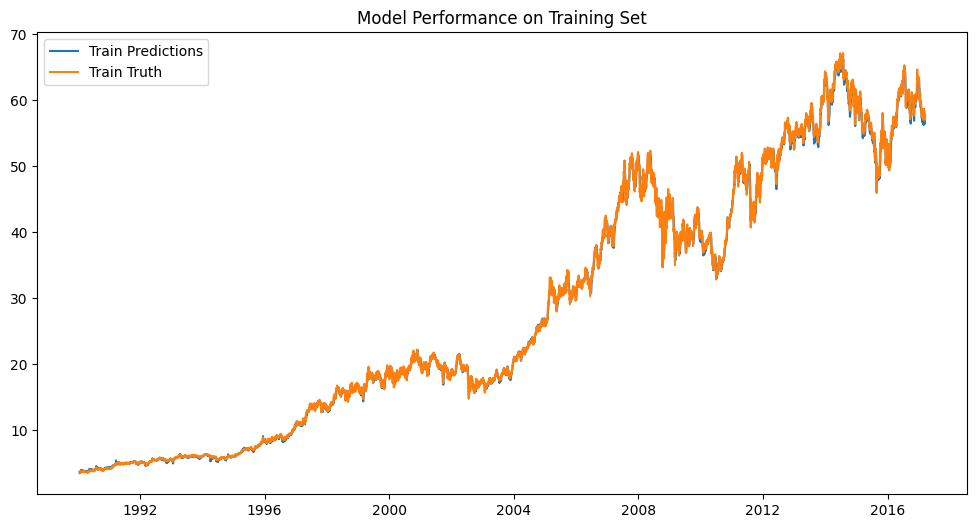

In [244]:
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_pred, label='Train Predictions')
plt.plot(dates_train, y_train_original, label='Train Truth')
plt.title('Model Performance on Training Set')
plt.legend()
plt.show()

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Set MAE: 3.7816
Test Set MSE: 25.9283
Test Set RMSE: 5.0920


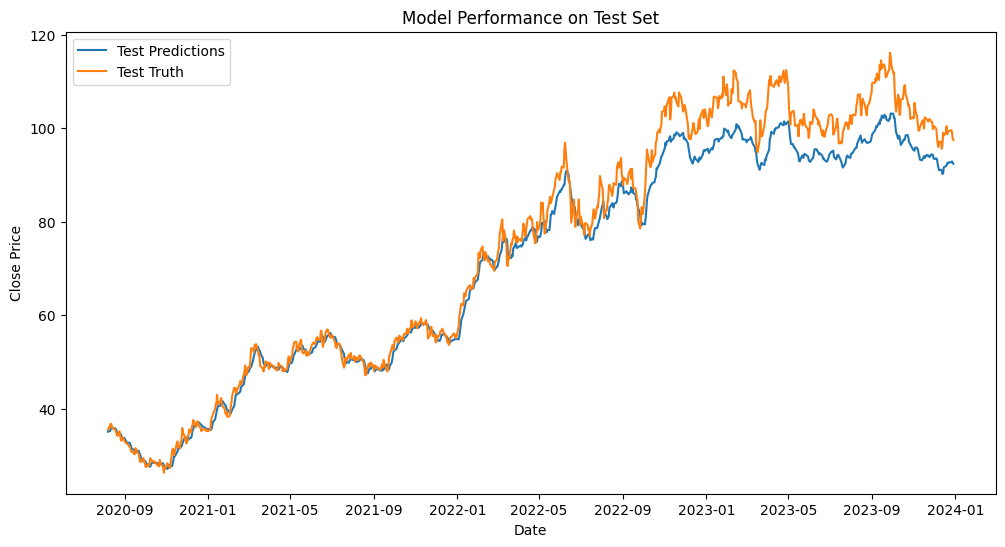

In [246]:
test_pred = model.predict(X_test).flatten()
test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_original, test_pred)
mse = mean_squared_error(y_test_original, test_pred)
rmse = np.sqrt(mse)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_pred, label='Test Predictions')
plt.plot(dates_test, y_test_original, label='Test Truth')
plt.title('Model Performance on Test Set')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()